In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib.pyplot import figure
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.tbats import TBATS
from sktime.transformations.series.boxcox import BoxCoxTransformer

In [ ]:
df = pd.read_csv("train.csv")
df["service_date"] = pd.to_datetime(df["service_date"])
df = df.drop("index", axis=1)
# df = df.set_index("service_date")

In [ ]:
df

,service_date,service_status,sum_price,hotel_id,hotel_category_star,hotel_max_rooms,hotel_type,city_name,region_name,country_name
0,2018-10-03,"Аннулировано, без штрафа",5117.000000,1037,4.0,74.0,hotel,Якутск,Якутия,Россия
1,2019-04-02,Подтвержден,2850.899902,5222,0.0,15.0,mini-hotel,Белгород,Белгородская область,Россия
2,2023-09-28,Подтвержден,3700.000000,35751,3.0,16.0,hotel,Жуковский,Московская область,Россия
3,2019-04-27,Подтвержден,15603.200195,2428,2.0,37.0,hotel,Казань,Татарстан,Россия
4,2023-04-08,Подтвержден,5915.000000,103399,3.0,105.0,hotel,Краснодар,Краснодарский край,Россия
...,...,...,...,...,...,...,...,...,...,...
5408815,2020-11-24,Подтвержден,12320.000000,2267,3.0,74.0,hotel,Туапсе,Краснодарский край,Россия
5408816,2023-02-13,Подтвержден,3288.250000,3257,3.0,66.0,hotel,Черкесск,Карачаево-Черкессия,Россия
5408817,2022-09-26,Подтвержден,506.000000,13935,0.0,7.0,hostel,Уфа,Башкортостан,Россия
5408818,2022-06-06,Подтвержден,2500.000000,130933,3.0,26.0,hotel,Тверь,Тверская область,Россия


In [ ]:
train = df.groupby(["service_date"])["sum_price"].sum()

In [ ]:
train = train.rename_axis("date").to_frame()

In [ ]:
train.index = train.index.to_period(freq="d")
train = train.sort_index()

<Axes: xlabel='date'>

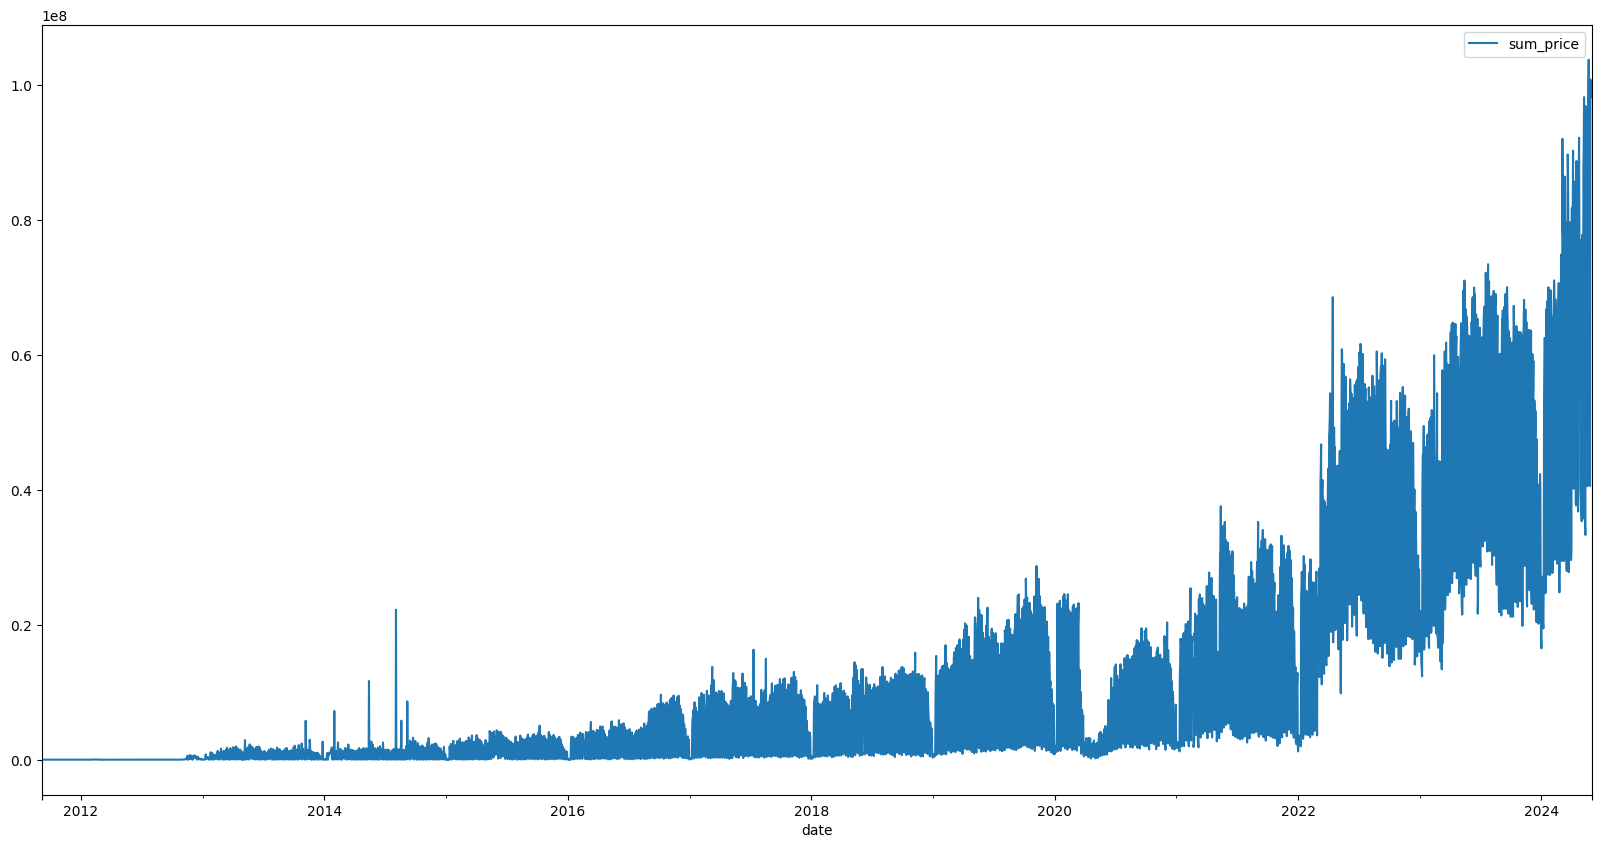

In [ ]:
train.plot(figsize=(20, 10))

In [ ]:
train

,sum_price
date,
2011-09-06,6.800000e+03
2011-09-13,6.741000e+03
2012-01-27,7.360000e+03
2012-02-13,3.776000e+04
2012-03-02,2.400000e+03
...,...
2024-05-27,1.007527e+08
2024-05-28,1.003180e+08
2024-05-29,9.832966e+07


In [ ]:
train = train["2022-02-24":]
train = train.reset_index()
train.columns = ["ds", "y"]
train["ds"] = train["ds"].dt.to_timestamp()

17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
/home/seara/Desktop/Github/mtc-time-series/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/seara/Desktop/Github/mtc-time-series/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


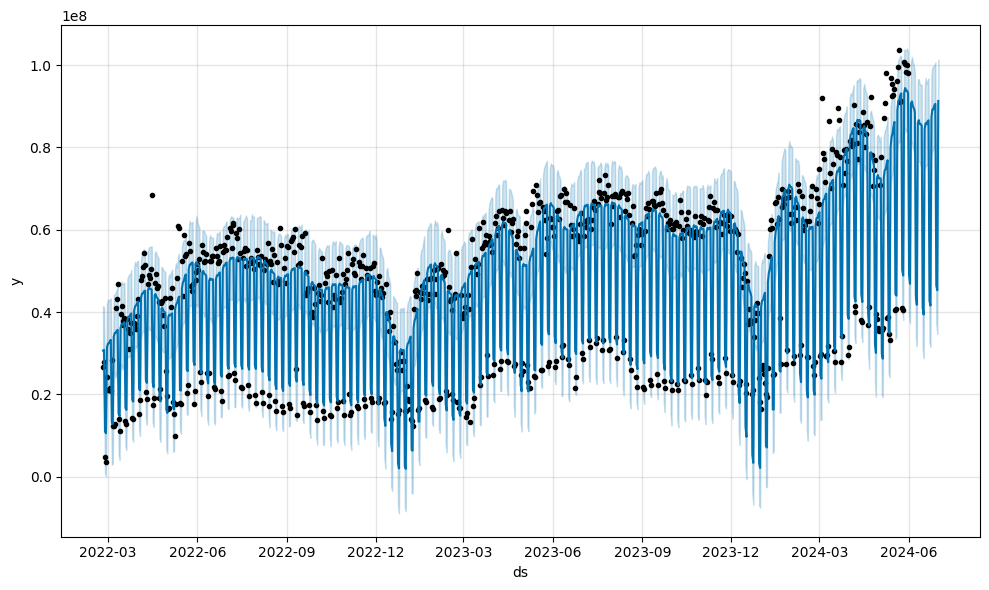

In [ ]:
m = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)
m.fit(train)
future = m.make_future_dataframe(periods=31)
forecast = m.predict(future)
fig = m.plot(forecast)

In [ ]:
pred = forecast[["ds", "yhat"]][-31:-1]
pred.columns = ["date", "forecast_value"]
pred.to_csv("default_prophet_multiplicative.csv", index=False)

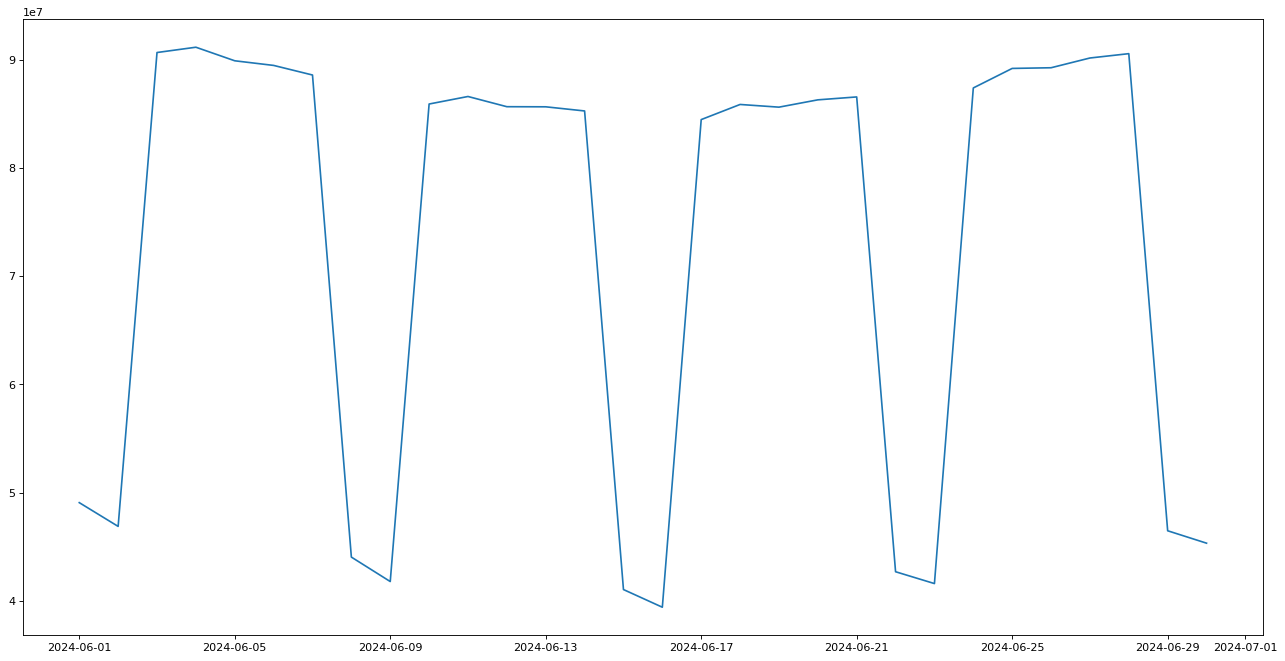

In [ ]:
figure(figsize=(20, 10), dpi=80)
plt.plot(pred.date, pred.forecast_value)

<Axes: >

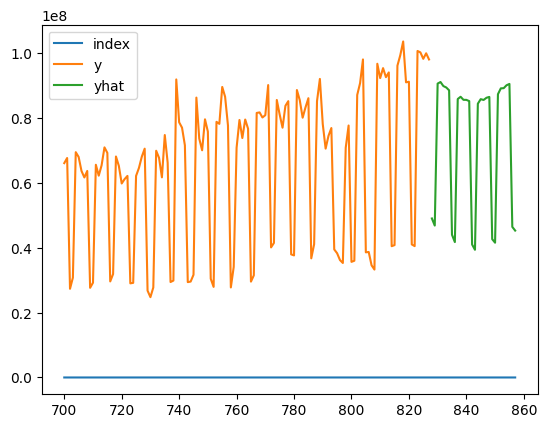

In [ ]:
pd.concat(
    [train, forecast.set_index("ds")["yhat"]["2024-06-01":"2024-06-30"].reset_index()]
).drop("ds", axis=1).reset_index()[700:].plot()

In [ ]:
train["sum_price"] = train["sum_price"].apply(lambda x: np.abs(x) + 0.001)

<Axes: xlabel='date'>

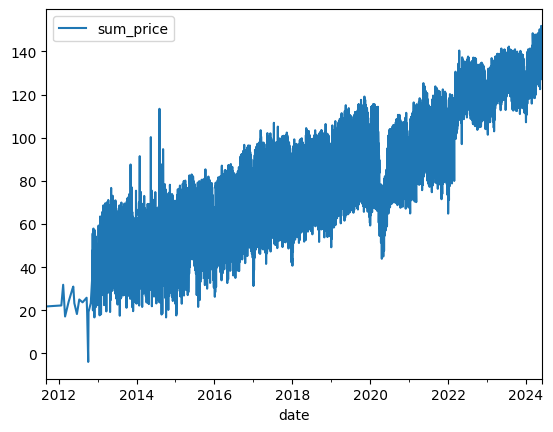

In [ ]:
transformer = BoxCoxTransformer(method="pearsonr")

y_hat = transformer.fit_transform(train)
y_hat.plot()

In [ ]:
transformer.get_fitted_params()

{'lambda': 0.17722534698212697}

<Axes: xlabel='date'>

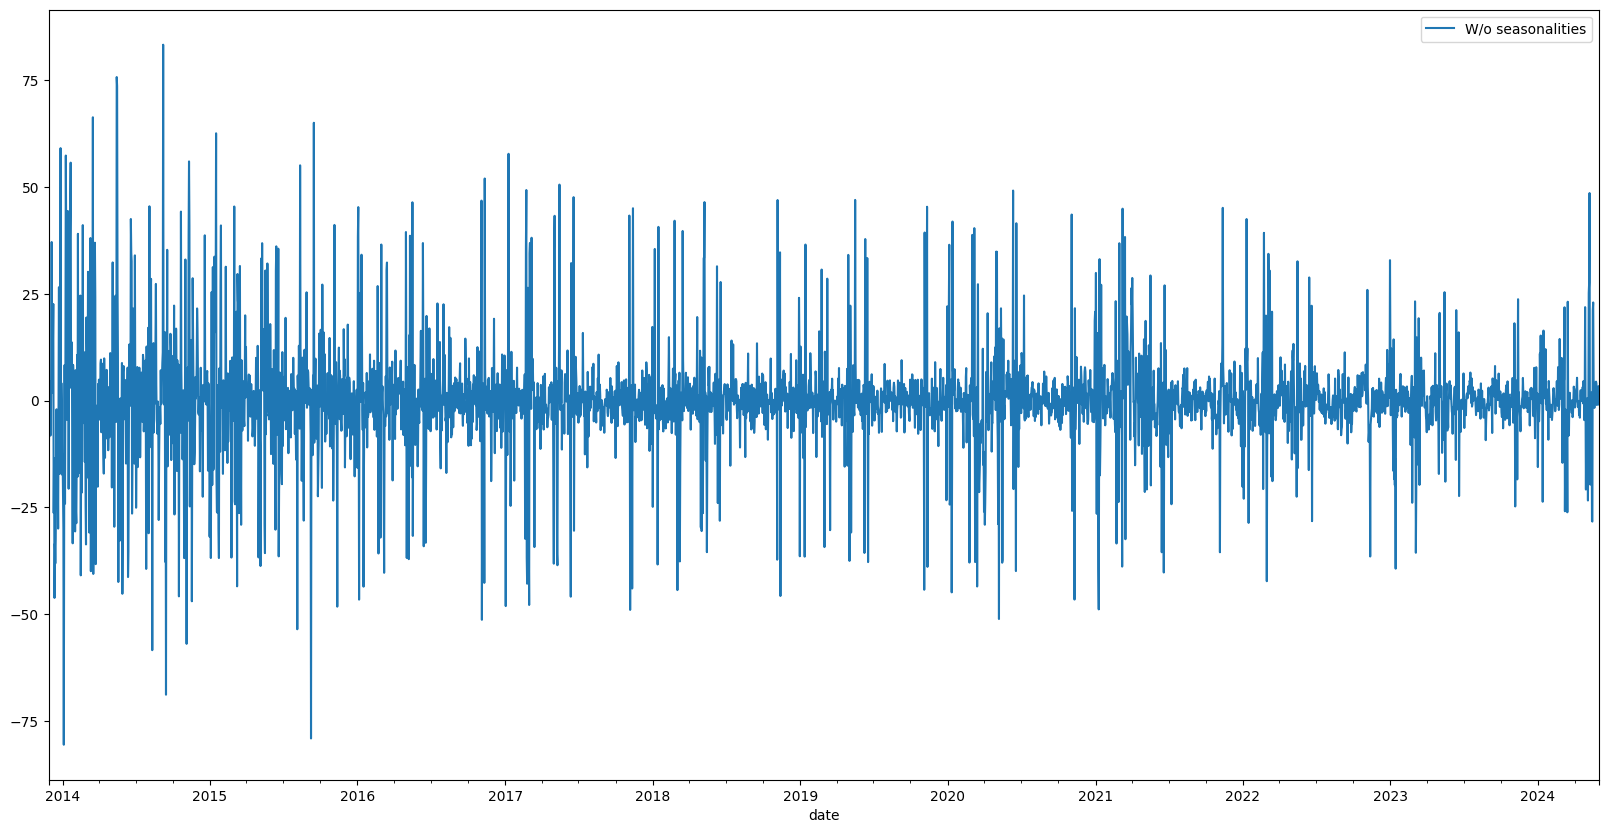

In [ ]:
stationary_ts = (y_hat["sum_price"] - y_hat["sum_price"].shift(7)).copy()[7:]
stationary_ts_yearly = (stationary_ts - stationary_ts.shift(365)).copy()[365:]
pd.DataFrame(
    {
        # "Original ts": train["sum_price"],
        # "W/o yearly seasonality": stationary_ts_yearly,
        "W/o seasonalities": stationary_ts_yearly,
    }
).plot(figsize=(20, 10))

In [ ]:
# train["sum_price"] = train["sum_price"].apply(lambda x: np.log(x) if x > 0 else 0)

In [ ]:
# stationary_ts_trend_removed = (train["sum_price"] - train["sum_price"].shift(1)).copy()[1:]
# stationary_ts_yearly = (stationary_ts_trend_removed/ stationary_ts_trend_removed.shift(365)).copy()[365:]
# stationary_ts = (stationary_ts_yearly - stationary_ts_yearly.shift(7)).copy()[7:]
# pd.DataFrame(
#     {
#         "Original ts": train["sum_price"],
#         # "W/o yearly seasonality": stationary_ts_yearly,
#         "W/o seasonalities":stationary_ts,
#     }
# )["2023-05-01":"2023-07-30"].plot()

<Axes: xlabel='date'>

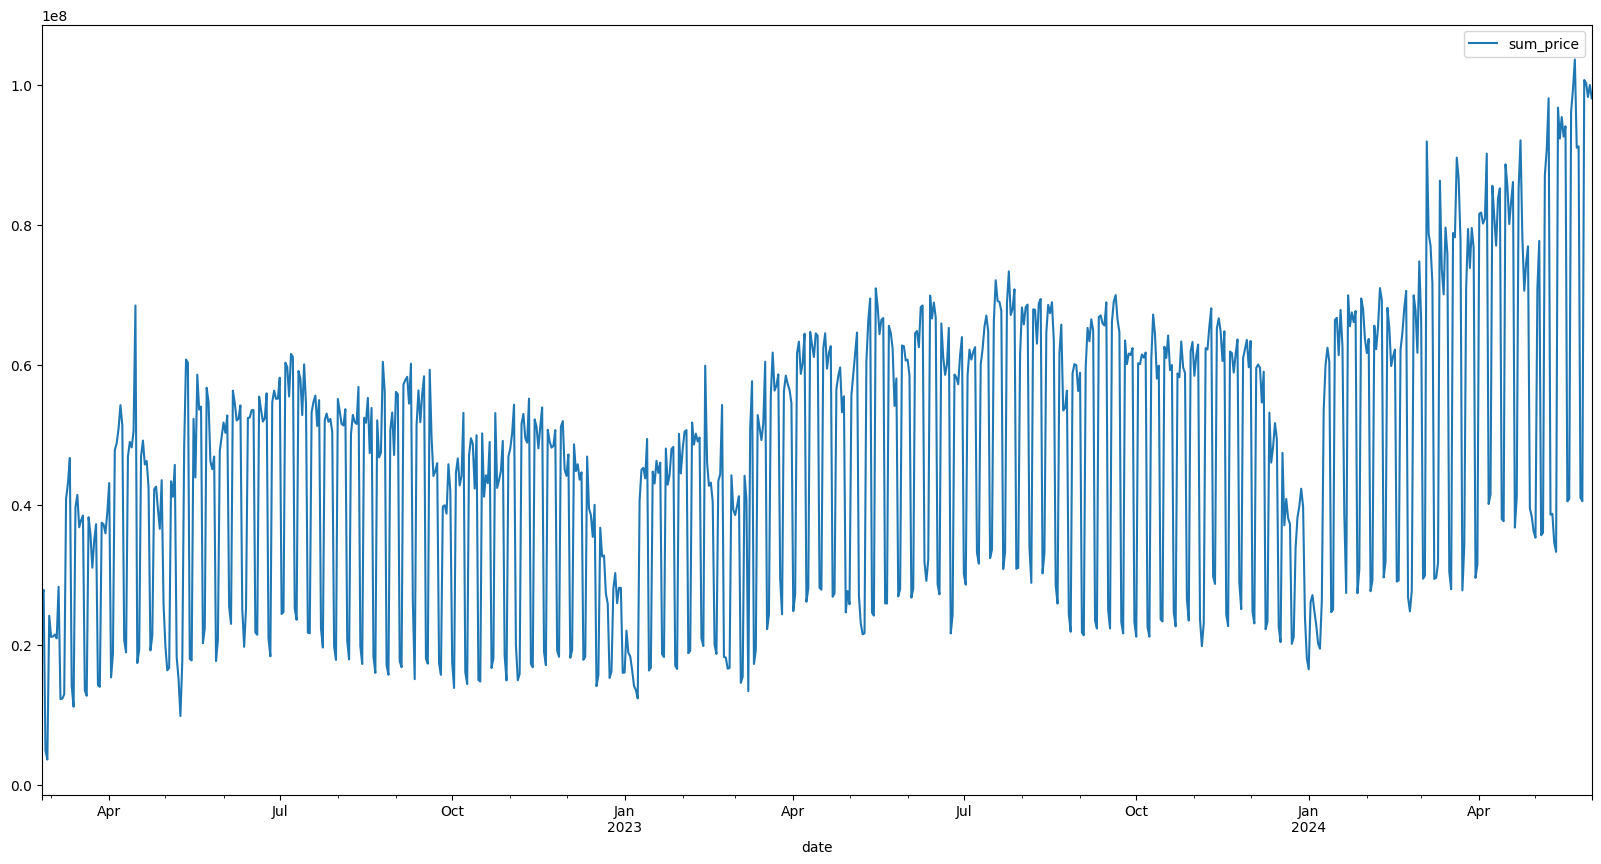

In [ ]:
train["2022-02-24":].plot(figsize=(20, 10))

<Axes: >

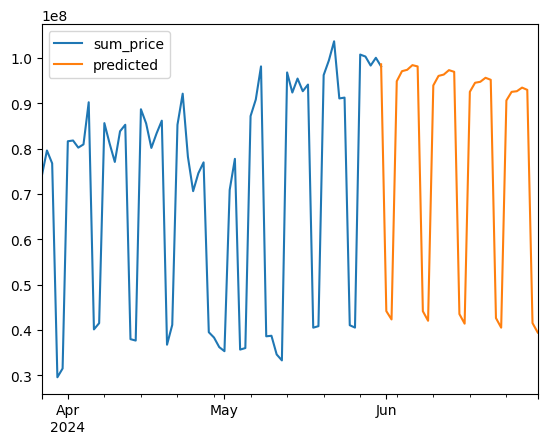

In [ ]:
forecaster = TBATS(use_box_cox=True, use_trend=True, use_damped_trend=False, sp=[7, 365])
forecaster.fit(train["2022-02-24":])

y_pred = forecaster.predict(fh=list(range(31)))
y_pred.columns = ["predicted"]
pd.concat([train, y_pred])["2024-03-27":].plot()

In [ ]:
submission = y_pred.reset_index()
submission.columns = ["date", "forecast_value"]
submission.to_csv("TBATS.csv", index=False)

In [ ]:
train["2022-01-01":].reset_index()

In [ ]:
pd.options.plotting.backend = "plotly"
train["2022-01-01":].reset_index()["sum_price"].plot()

In [ ]:
px.scatter(train, x="date", y="sum_price")

In [ ]:
train.loc["2024-05-05":].plot()

In [ ]:
train["sum_price"] = train["sum_price"].apply(lambda x: 0.00001 if x <= 0 else x)
train["sum_price"] = train["sum_price"].apply(lambda x: np.log(x))

In [ ]:
train["2024-01-8":].plot()

In [ ]:
forecaster = AutoARIMA(
    seasonal=True,
    sp=7,  # seasonal period, weekly
    d=1,  # differencing order
    D=1,  # seasonal differencing order
    start_p=1,
    start_q=1,  # starting AR and MA orders
    start_P=1,
    start_Q=1,  # starting seasonal AR and MA orders
    # suppress_warnings=True,
    max_p=2,
    max_q=2,
    max_Q=2,
    max_P=2,
)

forecaster.fit(train)

y_pred = forecaster.predict(fh=list(range(31)))

In [ ]:
pd.concat([train, y_pred]).tail(32)

In [ ]:
forecaster = SARIMAX(
    order=(1, 0, 1),  # (p, d, q)
    seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s)
)

# Fit the model
forecaster.fit(train)

# Forecast future values
y_pred = forecaster.predict(fh=list(range(31)))
y_pred.columns = ["predicted"]
pd.concat([train, y_pred])["2024-03-27":].plot()

In [ ]:
submission = y_pred.reset_index()
submission.columns = ["date", "forecast_value"]
submission.to_csv("arima_try.csv", index=False)

In [ ]:
forecaster = ExponentialSmoothing(trend="add", seasonal="add", sp=7)

forecaster.fit(train["2024-01-8":])

y_pred = forecaster.predict(fh=list(range(31)))
y_pred.columns = ["predicted"]

In [ ]:
pd.concat([train, y_pred])["2024-03-27":].plot()

In [ ]:
submission = y_pred.reset_index()
submission.columns = ["date", "forecast_value"]
submission["forecast_value"] = submission["forecast_value"].apply(lambda x: np.exp(x))

In [ ]:
submission.to_csv("simpleExponentialSmoothing_ver2.csv", index=False)

In [ ]:
temp = pd.concat([train, y_pred])["2024-03-27":]
temp["sum_price"] = temp["sum_price"].apply(lambda x: np.exp(x))
temp["predicted"] = temp["predicted"].apply(lambda x: np.exp(x))

In [ ]:
temp.tail(32)

In [ ]:
temp.plot()

In [ ]:
submission.plot()

In [ ]:
pd.concat([train, y_pred]).plot()

In [ ]:
y_pred

In [ ]:
train

In [ ]:
forecast

In [ ]:
train

In [ ]:
pd.concat([train, forecast.rename("forecast")], axis=1)

In [ ]:
pd.concat([train, forecast.rename("forecast")], axis=1)["2024-05-27":].plot()

In [ ]:
train.plot()

In [ ]:
df["hotel_id"].nunique()

In [ ]:
df.groupby(["hotel_id"])["sum_price"].sum()

In [ ]:
df[df["hotel_id"] == 343][["service_date", "sum_price"]]["service_date"].value_counts()

In [ ]:
a = df[df["hotel_id"] == 343][["service_date", "sum_price"]]
a = a.sort_values("service_date", ascending=True)
a.groupby("service_date").sum().plot()

In [ ]:
a

In [ ]:
plt.plot(a["service_date"], df["sum_price"])
plt.xticks(rotation="vertical")